In [25]:
using Unitful, UnitfulRecipes           # Unidades físicas
using FFTW                              # Transformadas de Fourier
using Plots, PlotThemes, ColorSchemes   # Gráficos
using Trapz                             # Integral Numérica

import PhysicalConstants.CODATA2014: c_0
c = c_0 |> u"km/ps"

theme(:juno)
default(size=(800,400), linewidth=2, palette=:seaborn_deep6)

In [26]:
N = 1024

P0 = 100u"mW"
T0 = 10u"ps"

λ = 1550u"nm"
α = uconvertp(NoUnits,0.02u"dB")*u"km^-1"
D = 18u"ps/(nm*km)"
γ = 1.2u"W^(-1)*km^(-1)"

β2 = -λ^2*D/(2π*c) |> u"ps^2/km"

-22.958067590909888 ps^2 km^-1

In [27]:
function ufft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return fft(yval, dim)*yunit
end
function uifft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return ifft(yval, dim)*yunit
end
function utrapz(x, y)
    xval, xunit = ustrip.(x), unit(x[1])
    yval, yunit = ustrip.(y), unit(y[1])
    return trapz(xval, yval)*yunit*xunit
end 

utrapz (generic function with 1 method)

In [28]:
function fwhm(x, y)
    maxy = maximum(y)
    n1 = findfirst(a -> a>maxy/2, y)
    n2 = findlast(a -> a>maxy/2, y)
    return x[n2]-x[n1]
end

fwhm (generic function with 1 method)

In [29]:
power(x, y) = utrapz(x, abs.(y).^2)

normalize(x, Ax, y, Ay) = Ay*sqrt(power(x, Ax)/power(y, Ay))

normalize (generic function with 1 method)

In [30]:
Leff = 1/α

P0 = 1/(γ*Leff)
T0 = sqrt(Leff*abs(β2))

LD = T0^2/abs(β2)
LNL = 1/(γ*P0) |> u"km"

B0 = 1/(2π*T0) |> u"GHz"

z = range(0u"km", 10*Leff, N)
h = z[2]-z[1]

Tf = sqrt(1+z[end]^2/LD^2)*T0
println("Longitud característica de atenuación = $Leff\nLongitud característica de dispersión = $LD\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de dispersión = 0.9954054173515269 km
Longitud característica de no-lineal. = 0.9954054173515269 km


In [31]:
t = range(-4*Tf, 4*Tf, N)
Δf = 1/(t[2]-t[1]) |> u"GHz"
f = fftfreq(N, Δf) |> fftshift;

At = zeros(N,N)*(0.0+im*0.0)*u"sqrt(mW/ps)";
Af = zeros(N,N)*(0.0+im*0.0)*u"sqrt(mW/GHz)";

T0 = 7.889727435163863 ps
B0 = 51.986111481108765 GHz


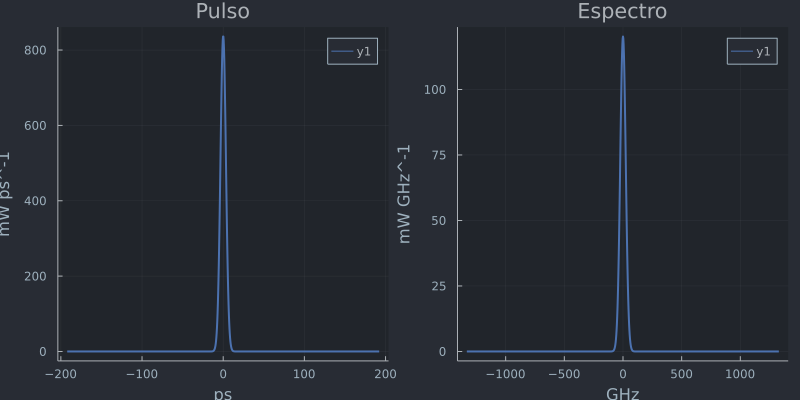

In [32]:
At[1,:] = sqrt(P0/u"ps")*exp.(-t.^2/(2*T0^2))
Af[1,:] = normalize(t, At[1,:], f, ufft(At[1,:]) |> fftshift)

p1 = plot(t, abs.(At[1,:]).^2, title="Pulso")
p2 = plot(f, abs.(Af[1,:]).^2, title="Espectro")
println("T0 = $(fwhm(t,abs.(At[1,:]).^2))\nB0 = $(fwhm(f,abs.(Af[1,:]).^2))")
plot(p1, p2)

In [33]:
A_spm(At) = At .* exp.(im*γ*abs.(At).^2*1u"ps"*h)
A_gvd(Af) = Af .* exp.(im*β2/2*(2π*f).^2*h)
A_att(Af) = Af .* exp.(-α*h/2)

A_att (generic function with 1 method)

In [34]:
function split_step(N_op, D_op)
    for i in 2:N
        AfD = D_op(Af[i-1,:])
        AtD = normalize(f, AfD, t, uifft(AfD))
        AtN = N_op(AtD) 
        
        Af[i,:] = normalize(t, AtN, f, ufft(AtN))
        At[i,:] = AtN 
    end
end

split_step (generic function with 1 method)

Primero evaluamos con únicamente atenuación

In [35]:
split_step(identity, A_att)

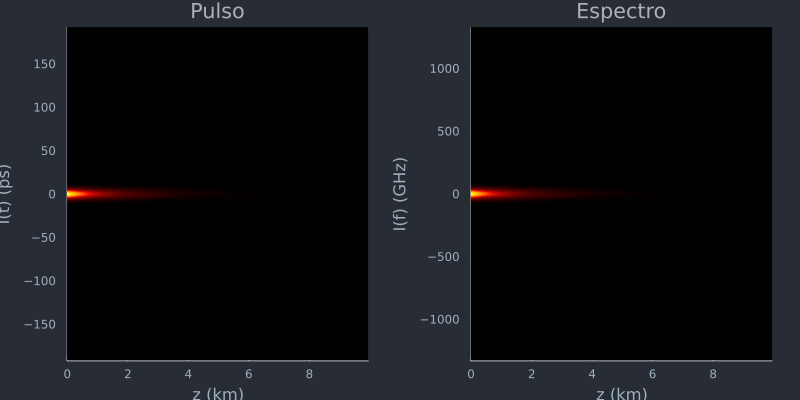

In [36]:
function heatmap_pulse(z, t, At, f, Af)
    p1 = heatmap(z, t, abs.(At').^2, xlabel="z", ylabel="I(t)", title="Pulso")
    p2 = heatmap(z, f, abs.(Af').^2, xlabel="z", ylabel="I(f)", title="Espectro")
    plot(p1, p2, layout=(1,2), colorbar=false, zaxis=:log)
end

heatmap_pulse(z, t, At, f, Af)

Únicamente dispersión

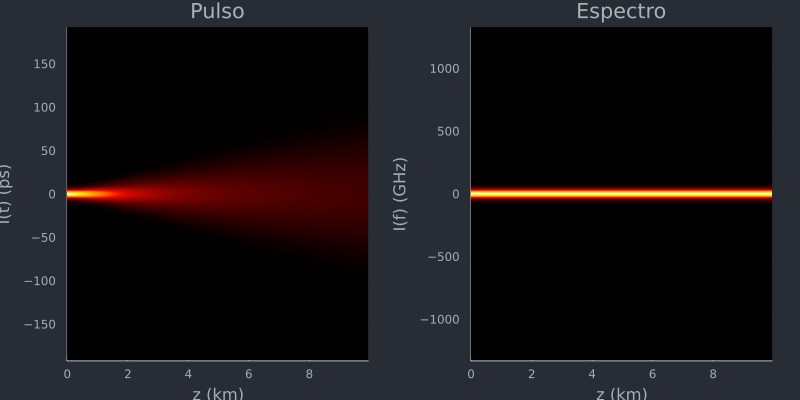

In [37]:
split_step(identity, A_gvd)

heatmap_pulse(z, t, At, f, Af)

Únicamente automodulación de fase

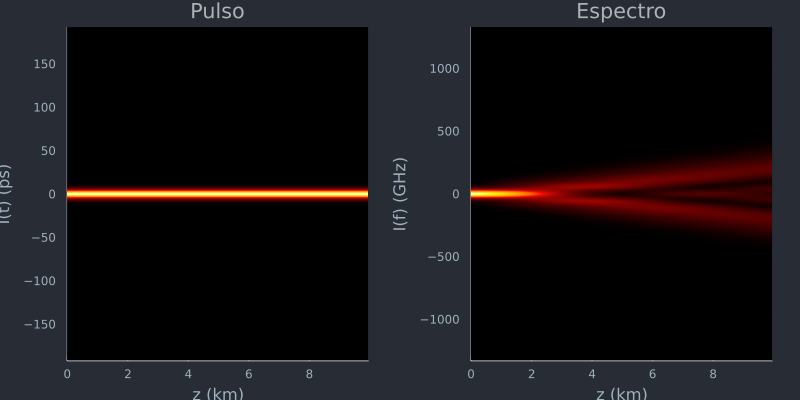

In [38]:
split_step(A_spm, identity)

heatmap_pulse(z, t, At, f, Af)

Efecto combinado de dispersión y automodulación de fase, solo porque se que esperar, incremento el rango de $z$

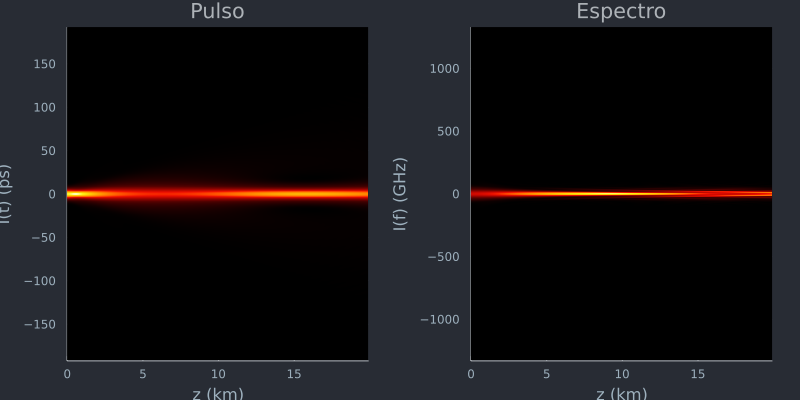

In [39]:
z = range(0u"km", 20*Leff, N)
h = z[2]-z[1]

split_step(A_spm, A_gvd)

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_u07cS2.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_u07cS2.gif")
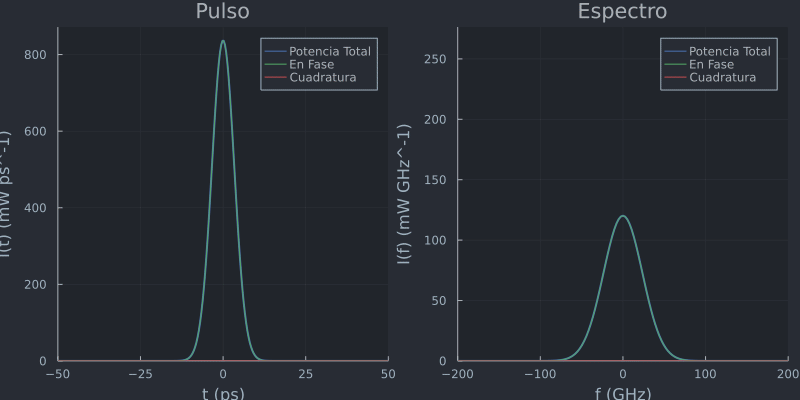

In [40]:
function animate_pulse(At, Af, tlims, flims)
    ylimsf = (0*unit(Af[1])^2, maximum(abs.(Af).^2))
    ylimst = (0*unit(At[1])^2, maximum(abs.(At).^2))
    
    @gif for i in 1:N   
        p2 = plot(f, abs.(Af[i,:]).^2, linewidth=2, xlims=flims, ylims=ylimsf, label="Potencia Total", xlabel = "f", ylabel = "I(f)", title="Espectro")
        plot!(f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)

        p1 = plot(t, abs.(At[i,:]).^2, linewidth=2, xlims=tlims, ylims=ylimst, label="Potencia Total", xlabel = "t", ylabel = "I(t)", title="Pulso")
        plot!(t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1)
        plot(p1, p2, layout=(1,2))
    end every 8
end

animate_pulse(At, Af, (-50, 50).*u"ps", (-200, 200).*u"GHz")

Se puede incluso incrementar muchísimo el rango de $z$ para ver que este comportamiento efectivamente se mantiene estable a lo largo de la fibra

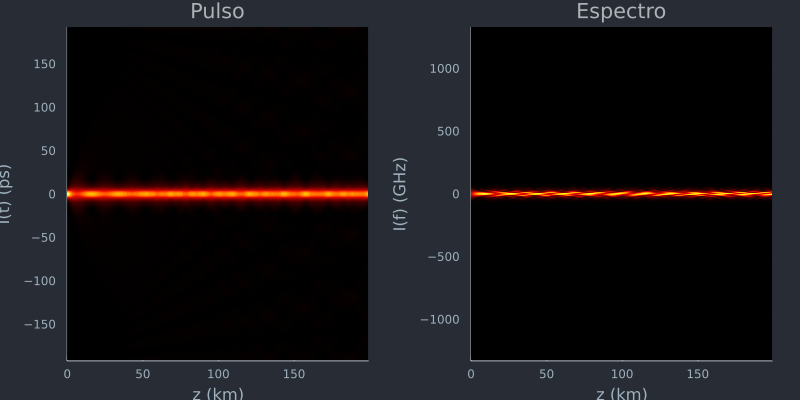

In [41]:
z = range(0u"km", 200*Leff, N)
h = z[2]-z[1]
split_step(A_spm, A_gvd)

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_7iGnhy.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_7iGnhy.gif")
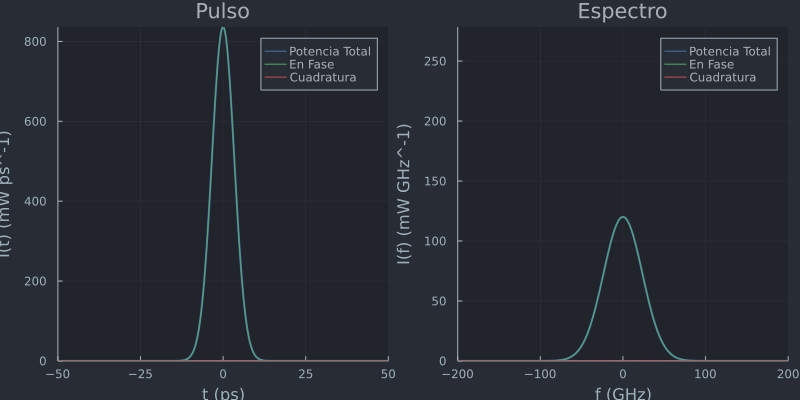

In [42]:
animate_pulse(At, Af, (-50, 50).*u"ps", (-200, 200).*u"GHz")

Y finalmente, todo junto, esperamos que el efecto del SPM disminuya con $z$ a lo largo de la línea por la atenuación, entonces elegimos distintas longitudes características tal que
$$L_{NL} < L_{eff} < L_{D}$$
De esta forma se espera que la automodulación de fase domine en $z < L_{eff}$, y que la dispersión domine en $z > L_{eff}$

In [43]:
P0 = 1/(γ*Leff/8)
T0 = sqrt(Leff*abs(β2)*2)

LD = T0^2/abs(β2)
LNL = 1/(γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de dispersión = $LD\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de dispersión = 1.9908108347030533 km
Longitud característica de no-lineal. = 0.12442567716894086 km


In [44]:
At[1,:] = sqrt(P0/u"ps")*exp.(-t.^2/(2*T0^2))
Af[1,:] = normalize(t, At[1,:], f, ufft(At[1,:]) |> fftshift)
z = range(0u"km", 4*Leff, N)
h = z[2]-z[1]

0.003892103293652109 km

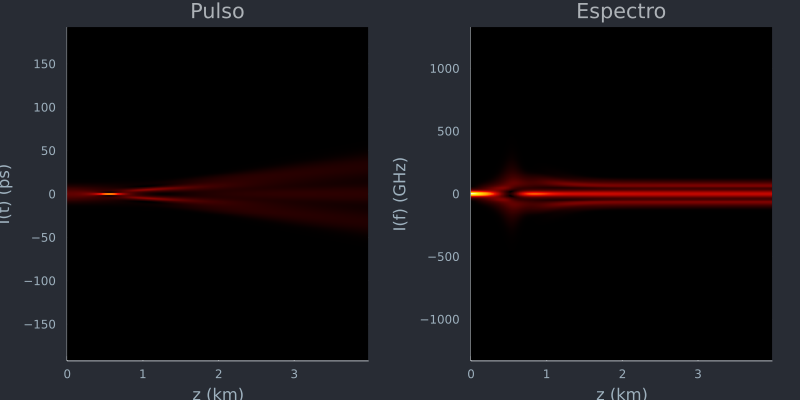

In [45]:
split_step(A_spm, A_gvd∘A_att)

normalize(x, Ax) = Ax/sqrt(power(x, Ax))

Atn = hcat([normalize(t, A) for A in eachrow(At)]...)';
Afn = hcat([normalize(f, A) for A in eachrow(Af)]...)';

heatmap_pulse(z, t, Atn, f, Afn)

┌ Info: Saved animation to 
│   fn = /tmp/jl_5g3YYv.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_5g3YYv.gif")
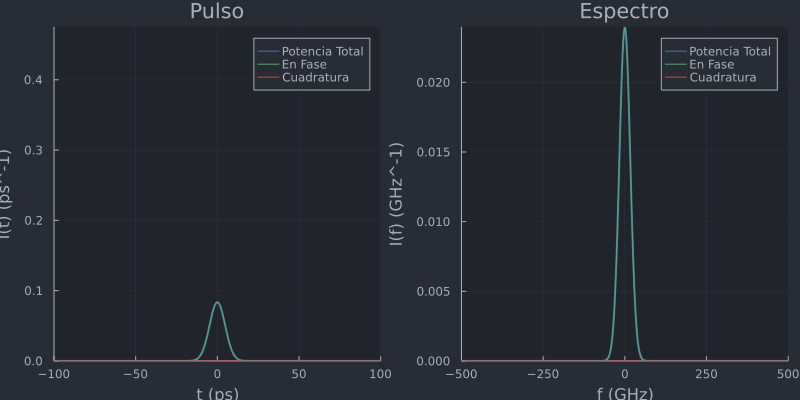

In [46]:
animate_pulse(Atn, Afn, (-100, 100).*u"ps", (-500, 500).*u"GHz")